In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

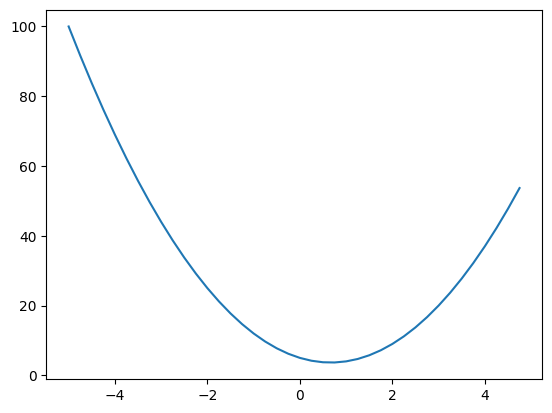

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h =0.000001
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [ ]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)

slope = (d2-d1)/h
print(slope)


d1 4.0
d2 4.0001
0.9999999999976694


In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

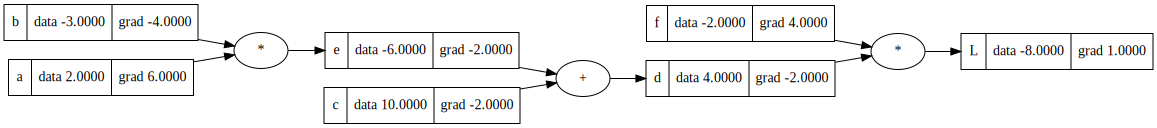

In [ ]:
L.backward()
draw_dot(L)

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [ ]:
def lol():
  h = 0.001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  f = e + c; f.label = 'f'
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  b.data += h
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  f = e + c; f.label = 'f'
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2-L1)/h)

lol()


7.435199999999753


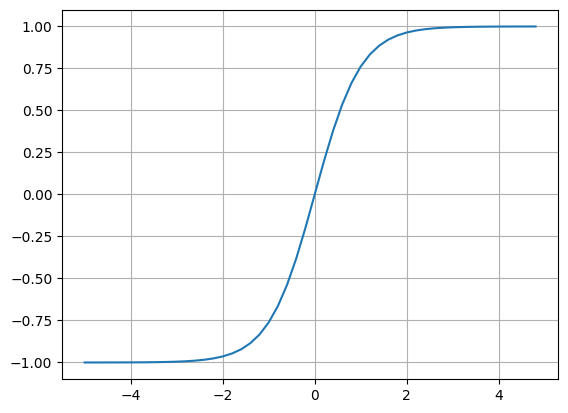

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [ ]:
#input
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights
w1 = Value(-3.0, label = 'w1')
w2 =Value(1.0, label = 'w2')
#bias
b = Value(6.881375548243455, label = 'b')
#x1x2 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; label = 'x1*w1 + x2*w2'
n = x1w1x2w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'



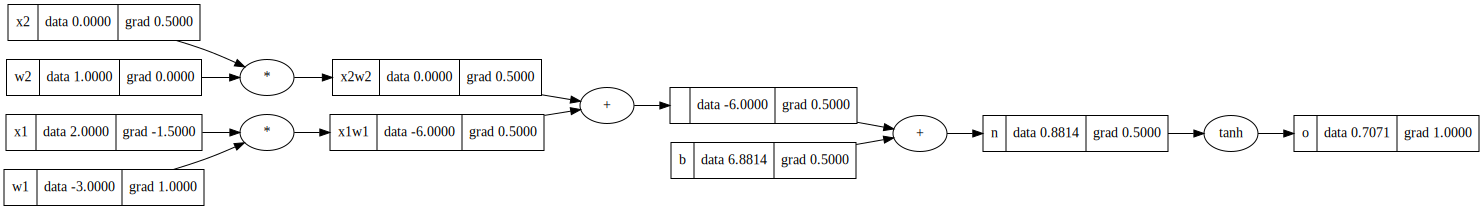

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881375548243455),
 Value(data=0.8813755482434553),
 Value(data=0.7071077617971437)]

In [ ]:
o.grad = 1.0

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()
x2w2._backward()

In [ ]:
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x2w2.grad

In [ ]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
n.grad = 0.5

In [ ]:
o.grad = 1.0

In [ ]:
1-o.data**2

0.49999861320623384

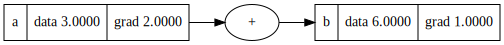

In [ ]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

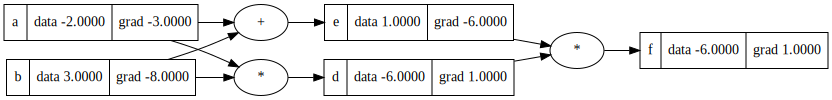

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; label = 'x1w1'
x2w2 = x2*w2; label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

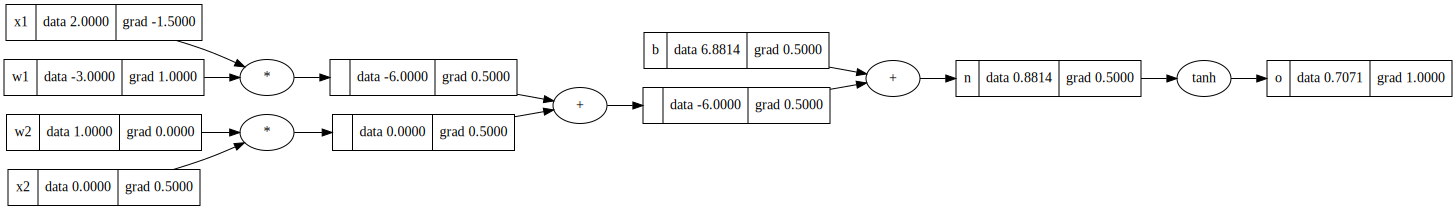

In [ ]:
draw_dot(o)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

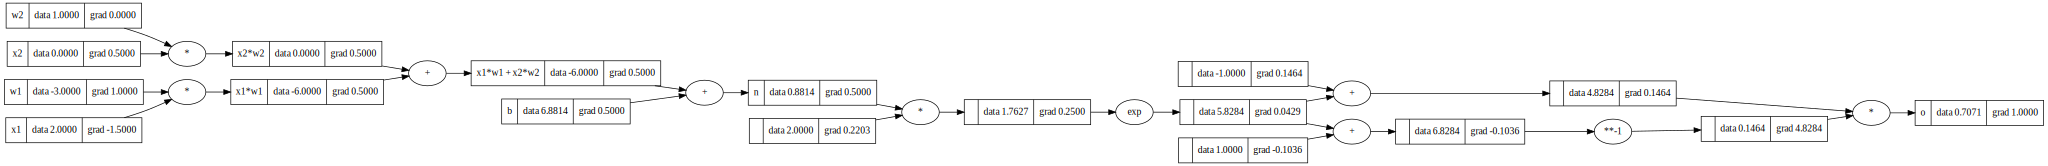

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch


In [ ]:
x1 = torch.Tensor([2.0]).double()                    ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()                    ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                   ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()                    ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double()      ;  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('---')
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7071066904050358
---
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


In [ ]:
import random
from random import uniform
import math

class Neuron:
  def __init__(self, nin):
    self.w = []
    for _ in range(nin):
      weight = Value(random.uniform(-1,1))
      self.w.append(weight)

    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = self.b
    for wi, xi in zip(self.w, x):
      act += wi*xi

    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = []
    for _ in range(nout):
      neuron = Neuron(nin)
      self.neurons.append(neuron)

  def __call__(self, x):
    outputs = []
    for neuron in self.neurons:
      out = neuron(x)
      outputs.append(out)

    if len(outputs) == 1:
      return outputs[0]
    return outputs

  def parameters(self):
    all_params = []
    for neuron in self.neurons:
      all_params.extend(neuron.parameters())
    return all_params

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = []
    for i in range(len(nouts)):
      layer = Layer(sz[i], sz[i+1])
      self.layers.append(layer)

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    all_params = []
    for layer in self.layers:
      all_params.extend(layer.parameters())
    return all_params

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.34008590938081507)

In [ ]:
xs = [[2.0, 3.0, -1],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

ys = [-1.0, 1.0, 1.0, -1.00]

In [ ]:
for k in range(30):
  ypred = []
  for x in xs:
    y = n(x)
    ypred.append(y)

  loss = 0
  for ygt, yout in zip(ys, ypred):
    diff = yout - ygt
    loss = loss + diff**2

  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  for p in n.parameters():
    p.data = p.data - 0.1*p.grad

  print(k, loss.data)


0 0.01471938944171387
1 0.014061413147036295
2 0.013459275263382517
3 0.012906054336119905
4 0.012395947914436059
5 0.011924051522862227
6 0.011486188719464257
7 0.011078778839018559
8 0.01069873292131838
9 0.010343370986932917
10 0.010010355669515816
11 0.009697638514554404
12 0.009403416183642762
13 0.009126094475780819
14 0.008864258569693901
15 0.00861664825593364
16 0.00838213720051299
17 0.008159715488131235
18 0.007948474850373626
19 0.007747596105275716
20 0.00755633842845912
21 0.007374030149329823
22 0.007200060823483054
23 0.007033874378118778
24 0.006874963163661799
25 0.0067228627739576744
26 0.0065771475209393995
27 0.006437426468732608
28 0.0063033399477042135
29 0.0061745564816832205


In [ ]:
ypred

[Value(data=-0.9605692423258106),
 Value(data=0.9735443160532261),
 Value(data=0.954223769401379),
 Value(data=-0.9572869419262345)]